In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.2.0
 GPU: /device:GPU:0


In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('acc')>=0.95):
            print("\nReached 95% accuracy ")
            self.model.stop_training = True

callbacks = myCallback()

In [3]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

144
167
37
42


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# rescale val data
val_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#set batch Size
batch_size = 10

#set Image size
imsize = (400,400) 
imshape = (400,400,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 311 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [5]:
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [6]:
#base model, fully trainable but started w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top=False, 
                                             weights='imagenet')

base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
final_layer = base_model.get_layer('out_relu')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 13, 13, 1280)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
_________________________________________________

In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=acc_metric)

In [9]:
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 100,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/100
31/31 [==============================] - 77s 2s/step - loss: 6.3854 - acc: 0.7581 - val_loss: 1.2393 - val_acc: 0.8714
Epoch 2/100
31/31 [==============================] - 76s 2s/step - loss: 1.8858 - acc: 0.8472 - val_loss: 1.5876 - val_acc: 0.8000
Epoch 3/100
31/31 [==============================] - 75s 2s/step - loss: 1.8978 - acc: 0.8439 - val_loss: 3.1385 - val_acc: 0.7000
Epoch 4/100
31/31 [==============================] - 75s 2s/step - loss: 1.4231 - acc: 0.8771 - val_loss: 1.3527 - val_acc: 0.8286
Epoch 5/100
31/31 [==============================] - 76s 2s/step - loss: 1.9745 - acc: 0.8140 - val_loss: 1.5117 - val_acc: 0.8143
Epoch 6/100
31/31 [==============================] - 74s 2s/step - loss: 1.3746 - acc: 0.8439 - val_loss: 1.0423 - val_acc: 0.8286
Epoch 7/100
31/31 [==============================] - 78s 3s/step - loss: 1.1686 - acc: 0.8505 - val_loss: 1.2373 - val_acc: 0.8286
Epoch 8/100
31/31 [==============================] - 74s 2s/step - loss: 1.2402 - a

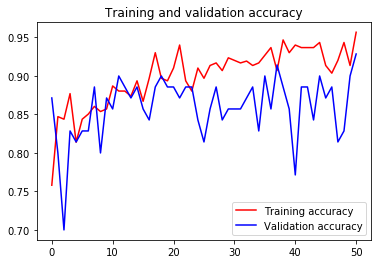

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [11]:
#save the model
fp='./saved_MobileNetV2'
tf.keras.models.save_model(model,fp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_MobileNetV2/assets
